In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Video info

Есть информация о 481_480, что в целом не является большим числом. Они разделены на 40 категорий, можно все учитывать. Авторов — 125_442, многие из них имеют только одно или мало видео, что не несет много информации. Длительность дана в миллисекундах, а в наборе событий — секундах, надо это учесть.

Кроме этого известны названия, они наверняка содержат полезную информацию, для работы с ними будем использовать предобученную языковую модель.

In [2]:
video_info = pd.read_csv("./data/video_info_v2.csv")
video_info["duration"] //= 1000
video_info

,rutube_video_id,title,category,duration,author_id
0,video_185549,Как собрать букет из мыльных тюльпанов - Силик...,Хобби,1559,1015054
1,video_111035,"Осторожно, Киберземляне!, 1 сезон, 12 серия",Сериалы,1320,1002180
2,video_476517,ПОПУЛЯРНЫЕ ВИДЕОИГРЫ в LEGO... перевод - TD BR...,Хобби,606,1095337
3,video_157198,"Хороший лжец (фильм, 2019)",Фильмы,6577,1043618
4,video_289824,Нашего старого гнобят по-всякому,Развлечения,859,1009535
...,...,...,...,...,...
481475,video_196126,14. Landscape Layer Blend,Дизайн,462,1121338
481476,video_390909,Рихард Штраус: Завтра! — Людмила Рубинская,Музыка,227,1043510
481477,video_326364,"Поймай Тинипин! Королевство эмоций, 2 серия. С...",Мультфильмы,744,1002799
481478,video_374957,ВОРКУТА. 1 СЕРИЯ. УЖАСЫ. ПСИХОЛОГИЧЕСКИЙ ТРИЛЛЕР,Люди и блоги,2597,1008386


In [3]:
video_info["category"].nunique()

40

In [4]:
video_info["category"].value_counts()

Разное                          141342
Сериалы                          49860
Телепередачи                     35510
Видеоигры                        33585
Музыка                           27295
Развлечения                      22506
Фильмы                           16579
Обучение                         13206
Лайфстайл                        12438
Юмор                             10281
Детям                            10227
Авто-мото                         8212
Аниме                             7504
Спорт                             7490
Интервью                          7115
Мультфильмы                       6374
Еда                               5788
Эзотерика                         5765
Путешествия                       5481
Технологии и интернет             5044
Хобби                             4744
Культура                          4301
Техника и оборудование            4223
Аудиокниги                        3880
Здоровье                          3518
Психология               

In [5]:
video_info["author_id"].nunique()

125442

In [6]:
video_info["author_id"].value_counts()

1095392    8603
1043618    8277
1009219    7391
1048955    5638
1000015    5308
           ... 
1026823       1
1108769       1
1008028       1
1076567       1
1007868       1
Name: author_id, Length: 125442, dtype: int64

In [7]:
video_info["duration"].describe().astype(int)

count    481480
mean       1660
std        2582
min         180
25%         347
50%         816
75%        2340
max       89244
Name: duration, dtype: int32

## Train events

In [8]:
events = pd.read_csv("./data/train_events.csv", parse_dates=True)
events

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid
0,2024-06-01 06:40:58+03:00,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243
1,2024-06-01 19:33:24+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341
2,2024-06-01 21:30:43+03:00,St.-Petersburg,desktop,browser,Windows,Chrome,5647,video_96775,10894333
3,2024-06-01 23:03:42+03:00,Moscow,smartphone,mobile app,Android,Rutube,1521,video_161610,10029092
4,2024-06-01 22:48:09+03:00,Moscow,smartphone,mobile app,Android,Rutube,71,video_116245,10452976
...,...,...,...,...,...,...,...,...,...
1759611,2024-06-30 17:08:36+03:00,Moscow,smartphone,mobile app,Android,Rutube,4230,video_162776,10026914
1759612,2024-06-30 01:20:16+03:00,Moscow,smartphone,browser,Android,Firefox Mobile,382,video_316157,10417567
1759613,2024-06-30 22:37:04+03:00,St.-Petersburg,desktop,browser,Windows,Microsoft Edge,1342,video_83304,10009094
1759614,2024-06-30 11:33:09+03:00,St.-Petersburg,smartphone,mobile app,Android,Rutube,801,video_132769,10574374


даны события за один месяц

In [9]:
events["event_timestamp"].min(), events["event_timestamp"].max()

('2024-06-01 00:00:02+03:00', '2024-06-30 23:59:26+03:00')

116 регионов, есть редкие

In [10]:
events.groupby("region")["viewer_uid"].nunique().sort_values(ascending=False)

region
Moscow                    69571
Moscow Oblast             27115
St.-Petersburg            23707
Sverdlovsk Oblast          9974
Bashkortostan Republic     9182
                          ...  
Astrakhan                    21
Nenets                       18
Ingushetiya Republic         18
Stavropol Krai               13
Arkhangelsk Oblast            3
Name: viewer_uid, Length: 116, dtype: int64

у этих всего 3 различных значения

"av" не стоит учитывать

In [11]:
events.groupby("ua_device_type")["viewer_uid"].nunique().sort_values(ascending=False)

ua_device_type
smartphone    123650
desktop        61331
tablet         18559
Name: viewer_uid, dtype: int64

In [12]:
events.groupby("ua_client_type")["viewer_uid"].nunique().sort_values(ascending=False)

ua_client_type
browser       97883
mobile app    91527
av                4
Name: viewer_uid, dtype: int64

здесь различных значения побольше, все равно уберем редкие

In [13]:
events.groupby("ua_os")["viewer_uid"].nunique().sort_values(ascending=False)

ua_os
Android                 117812
Windows                  52742
iOS                      15717
Mac                       8358
GNU/Linux                 3495
iPadOS                     285
Windows Phone              251
Ubuntu                     176
MeeGo                       62
BlackBerry OS               59
Fire OS                     57
BlackBerry Tablet OS        53
Windows CE                  50
KaiOS                       19
android tv                  16
MocorDroid                  12
Windows RT                   9
Symbian                      9
Symbian OS Series 60         5
HarmonyOS                    3
Chrome OS                    2
NetBSD                       1
SUSE                         1
OpenBSD                      1
Fedora                       1
Debian                       1
CentOS                       1
wear os                      1
Name: viewer_uid, dtype: int64

In [14]:
events.groupby("ua_client_name")["viewer_uid"].nunique().sort_values(ascending=False)

ua_client_name
Rutube                        91087
Yandex Browser                30331
Chrome                        25335
Chrome Mobile                 21335
Firefox Mobile                12880
Mobile Safari                 11677
Microsoft Edge                 4803
Firefox                        3556
Safari                         3502
Opera                          2956
Chrome Mobile iOS              2516
Android Browser                 847
Opera Mini                      580
Opera Mobile                    418
Samsung Browser                 404
Google Search App               351
Chrome Webview                  321
MIUI Browser                    267
Atom                            258
Internet Explorer               170
Huawei Browser Mobile           131
Opera GX                        118
Opera Touch                      82
BlackBerry Browser               73
RDDocuments                      66
IE Mobile                        64
Nokia Browser                    62
Mobile Silk  

в истории встретилось 126_248 видео из 481_480, т.е. только четверть попала в обучение

In [15]:
events["rutube_video_id"].nunique()

126248

видно что у большенства пользователей малая история просмотра, меньше 64 у 98%, но есть и те, кто смотрел много видео

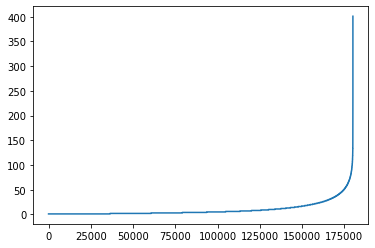

In [16]:
plt.plot(events["viewer_uid"].value_counts().values[::-1])

In [17]:
events["viewer_uid"].value_counts().value_counts()

1      36337
2      24342
3      18406
4      14442
5      11168
       ...  
142        1
140        1
137        1
133        1
401        1
Name: viewer_uid, Length: 165, dtype: int64

# All events

In [18]:
all_events = pd.read_csv("./data/all_events.csv", parse_dates=True)
all_events

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid
0,2024-06-01 13:08:30+03:00,Tatarstan Republic,smartphone,browser,Android,Chrome Mobile,60,video_395879,10813370
1,2024-06-01 14:30:00+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,60,video_216518,10512324
2,2024-06-01 18:48:12+03:00,Novosibirsk Oblast,smartphone,mobile app,Android,Rutube,121,video_41225,10951137
3,2024-06-01 16:32:36+03:00,Moscow,desktop,browser,Windows,Yandex Browser,2324,video_215886,10912434
4,2024-06-01 00:57:04+03:00,Moscow Oblast,smartphone,mobile app,Android,Rutube,6830,video_43631,10223585
...,...,...,...,...,...,...,...,...,...
8439619,2024-06-30 18:12:06+03:00,Nizhny Novgorod Oblast,smartphone,mobile app,Android,Rutube,1735,video_163270,10687999
8439620,2024-06-30 09:23:08+03:00,Chelyabinsk,smartphone,mobile app,Android,Rutube,4766,video_433627,10425804
8439621,2024-06-30 10:57:36+03:00,Krasnodar Krai,smartphone,mobile app,Android,Rutube,890,video_11911,10565147
8439622,2024-06-30 18:16:55+03:00,Moscow,smartphone,browser,Android,Yandex Browser,2504,video_252573,10715847


Также известны события для неразмеченных пользователей, их аж в 8 раз больше. Можно использовать для предобучения нейросетей.